<a href="https://colab.research.google.com/github/chavgova/My-AI/blob/master/emotion_recognition_10_male.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SPEECH RECOGNITION**

In [1]:
#this is the copy of another projecct and ill make changes to see how i can make it better 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from matplotlib.axis import Axis
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import os
import pandas as pd


In [3]:
from google.colab import drive
import os

path = '/content/drive/My Drive/My_AI/RawData'

mylist = []
mylist = os.listdir(path)

#print(mylist)	



In [4]:
print(len(mylist))

4642


# LABLES & FEATURES

In [5]:
import re

feeling_list=[]
dataset = ''

for item in mylist:
    file_label = item[6:-16]
    try:
      file_label = int(file_label)
      dataset = 'RAVDESS'
    except:
      if (item[:1] == 'Y') or (item[:1] == 'O'):
        file_label = re.split('_|\.', item)[2]
        dataset = 'TESS'
      else: dataset = 'SAVEE'

    if dataset == 'RAVDESS':
      if int(item[18:-4])%2==0:  #female
          if file_label == 1:
            feeling_list.append('female_neutral')
          elif file_label == 2:
            feeling_list.append('female_calm')
          elif file_label == 3:
            feeling_list.append('female_joy')
          elif file_label == 4:
            feeling_list.append('female_sadness')
          elif file_label == 5:
            feeling_list.append('female_anger')
          elif file_label == 6:
            feeling_list.append('female_fear')
          elif file_label == 7:
            feeling_list.append('female_disgust')
          elif file_label == 8:
            feeling_list.append('female_surprise')
      else:
          if file_label== 1:
            feeling_list.append('male_neutral')
          elif file_label == 2:
            feeling_list.append('male_calm')
          elif file_label == 3:
            feeling_list.append('male_joy')
          elif file_label == 4:
            feeling_list.append('male_sadness')
          elif file_label == 5:
            feeling_list.append('male_anger')
          elif file_label == 6:
            feeling_list.append('male_fear')
          elif file_label == 7:
            feeling_list.append('male_disgust')
          elif file_label == 8:
            feeling_list.append('male_surprise')

    elif dataset == 'TESS':
      if file_label == 'neutral': feeling_list.append('female_neutral')
      elif file_label == 'angry': feeling_list.append('female_anger')
      elif file_label == 'disgust': feeling_list.append('female_disgust')
      elif file_label == 'ps': feeling_list.append('female_surprise')
      elif file_label == 'happy': feeling_list.append('female_joy')
      elif file_label == 'sad': feeling_list.append('female_sadness')
      elif file_label == 'fear': feeling_list.append('female_fear')

    elif dataset == 'SAVEE':
      if item[:1]=='a':
        feeling_list.append('male_anger')
      elif item[:1]=='f':
        feeling_list.append('male_fear')
      elif item[:1]=='h':
        feeling_list.append('male_joy')
      elif item[:1]=='n':
        feeling_list.append('male_neutral')
      elif item[:2]=='sa':
        feeling_list.append('male_sadness')
      elif item[:2]=='su':
        feeling_list.append('male_surprise')
      elif item[:1]=='d':
        feeling_list.append('male_disgust')


In [6]:
import pandas as pd

labels = pd.DataFrame(feeling_list)
labels #[1600:1660]      #print

,0
0,female_disgust
1,female_fear
2,female_disgust
3,female_surprise
4,female_disgust
...,...
4637,male_surprise
4638,female_calm
4639,male_surprise
4640,male_anger


Getting the features of audio files using librosa

In [7]:
import librosa
import numpy as np

def extract_feature(my_file, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(my_file)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))  # 40 values 
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))  # 12 values 
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))  # 128 values 
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast)) # 7 values 
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz)) # 6 values 

    return result

#f = os.fspath('/content/drive/My Drive/My_AI/RawData/03-01-08-01-01-02-01.wav')
#a = extract_feature(f, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
#print(a, a.shape)

In [ ]:
data_frame = pd.DataFrame(columns=['all_features'])
bookmark=0

#mylist = mylist[:100]
for index,y in enumerate(mylist):
      all_features_ndarray = extract_feature('/content/drive/My Drive/My_AI/RawData/'+ y, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
      data_frame.loc[bookmark] = [all_features_ndarray]
      bookmark=bookmark+1
        
#df[:5]    #print 


In [ ]:
data_frame

,all_features
0,"[-450.4467902687698, 52.78477496423427, 15.648..."
1,"[-272.2313050032326, 24.005224351076567, -12.7..."
2,"[-373.1040202663822, 66.16137456128594, 7.5169..."
3,"[-318.62595540382716, 19.142114664456766, -7.3..."
4,"[-392.23135301537667, 50.253868069087794, -12...."
...,...
4637,"[-592.73684969667, 45.527771233285556, -4.7814..."
4638,"[-658.8565616187757, 48.351727136391425, -8.86..."
4639,"[-684.0049888159394, 53.24508398711076, -3.824..."
4640,"[-304.1945719078139, 22.833493834270715, -20.7..."


In [ ]:
data_frame = pd.DataFrame(data_frame['all_features'].values.tolist())
data_frame[:10]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192
0,-450.446790,52.784775,15.648708,19.193057,2.475410,-7.208440,-5.635242,-8.170134,-14.528484,-2.096516,-10.965901,4.155924,-4.853765,-1.492693,-2.933875,-5.061808,2.107988,0.916129,-10.885692,4.819537,-5.774637,-0.762383,-0.935110,-0.634435,-3.342291,1.763979,-2.202200,8.918032,3.351551,6.947891,3.683188,5.685371,3.502511,4.452860,1.674134,2.716228,2.281020,3.055006,3.131090,2.367724,...,0.000076,0.000109,0.000155,0.000262,0.000296,0.000540,0.000615,0.000613,0.000655,0.000833,0.000978,0.000832,0.000789,0.000494,0.000770,0.001289,0.001923,0.001750,0.002413,0.003114,0.003965,0.002469,0.001116,0.000836,0.001403,0.000924,0.000097,17.319344,18.977130,20.407708,17.000817,20.148136,20.965748,30.240369,-0.002379,0.013807,0.019982,0.020457,0.005224,0.008329
1,-272.231305,24.005224,-12.781592,3.327530,-30.186335,-2.341174,-0.060594,-13.371215,-5.793734,-0.965795,-16.918876,9.527992,-7.867107,4.287767,-2.294043,-4.226135,2.519906,13.563799,-0.228995,11.708729,4.992145,6.400044,-0.541068,6.821878,2.586428,10.237659,2.813900,2.051348,-1.123593,2.798748,-4.497329,7.207094,-6.795181,0.614684,-1.950490,2.425818,3.162681,0.975054,-3.727393,4.367290,...,0.150933,0.115309,0.109462,0.123070,0.104159,0.093961,0.066167,0.061440,0.042861,0.029199,0.037947,0.034749,0.036481,0.040350,0.038601,0.028470,0.025962,0.022607,0.020995,0.018740,0.030697,0.031976,0.011916,0.012690,0.017069,0.008181,0.000816,14.060692,22.722685,23.871710,22.137277,21.382867,21.876598,32.664161,0.002686,0.002253,-0.024685,-0.016318,-0.009026,-0.013298
2,-373.104020,66.161375,7.516917,5.097944,-16.838836,-2.175940,-5.913691,-11.850110,-6.135202,2.809906,-9.307024,4.042693,-6.130998,1.289580,-5.235035,-4.470139,-2.513943,-2.080210,-7.329186,0.200348,-6.900330,-1.473784,-3.858349,2.557553,-4.873826,1.982715,-3.334942,1.539641,1.644957,2.032889,1.157394,5.220535,3.729247,5.309881,2.627605,2.160911,2.327438,4.882227,4.379001,5.132598,...,0.001141,0.001483,0.001969,0.002732,0.002415,0.002843,0.003623,0.003531,0.003892,0.006023,0.007679,0.004798,0.003311,0.002908,0.004377,0.006770,0.009766,0.010519,0.010648,0.011662,0.009708,0.005729,0.003757,0.004323,0.003112,0.001136,0.000089,19.426547,19.018841,18.389283,16.064602,17.959455,21.543670,30.157556,-0.000647,0.004504,-0.025040,0.034154,-0.002565,0.005111
3,-318.625955,19.142115,-7.345348,-2.537345,-38.761333,2.039370,-2.714543,-13.773638,-7.656481,1.566409,-11.176822,4.877324,-2.935222,7.971349,-2.556961,7.952295,0.911417,13.423673,-1.479921,7.523744,-2.214864,5.246403,-5.114434,0.562009,-1.560729,2.974430,1.005293,6.339411,5.854998,9.672666,4.346792,6.068282,1.323393,5.295947,1.649687,2.769115,4.405043,5.208635,2.996643,5.976270,...,0.045567,0.046591,0.060627,0.063916,0.068098,0.052068,0.047295,0.030324,0.031193,0.023465,0.024152,0.019740,0.014662,0.011632,0.009050,0.009422,0.010417,0.007946,0.009308,0.010168,0.011324,0.006165,0.003117,0.002791,0.002684,0.001517,0.000120,19.769034,18.394825,21.589878,19.986837,19.548229,19.696211,32.830586,0.004874,-0.001074,0.000374,-0.053727,0.002502,0.003586
4,-392.231353,50.253868,-12.411759,15.013466,-8.051602,2.189021,-7.455515,-6.866833,-3.855636,1.317986,-11.238817,4.955630,-6.895823,4.709289,-3.745549,-2.827099,0.935937,-2.115366,-4.774835,0.245854,-8.875309,-1.538719,-4.398577,3.298068,-1.862946,1.051883,-0.236319,2.139946,-0.344671,5.405280,0.683606,7.784515,4.043098,2.286248,3.062294,3.104532,1.411313,3.224573,1.600605,5.101071,...,0.007936,0.007713,0.009837,0.008383,0.005049,0.004186,0.004053,0.003052,0.002230,0.002454,0.002093,0.001998,0.001364,0.001249,0.001986,0.003943,0.005768,0.005495,0.005249,0.005435,0.004907,0.002986,0.002460,0.002834,0.003057,0.002219,0.000231,18.696501,18.305210,18.977073,16.725505,19.214485,2

In [ ]:
data_frame_labels = pd.concat([data_frame,labels], axis=1)
data_frame_labels = data_frame_labels.rename(index=str, columns={"0": "label"})
data_frame_labels    #print

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
0,-450.446790,52.784775,15.648708,19.193057,2.475410,-7.208440,-5.635242,-8.170134,-14.528484,-2.096516,-10.965901,4.155924,-4.853765,-1.492693,-2.933875,-5.061808,2.107988,0.916129,-10.885692,4.819537,-5.774637,-0.762383,-0.935110,-0.634435,-3.342291,1.763979,-2.202200,8.918032,3.351551,6.947891,3.683188,5.685371,3.502511,4.452860,1.674134,2.716228,2.281020,3.055006,3.131090,2.367724,...,0.000109,0.000155,0.000262,0.000296,0.000540,0.000615,0.000613,0.000655,0.000833,0.000978,0.000832,0.000789,0.000494,0.000770,0.001289,0.001923,0.001750,0.002413,0.003114,0.003965,0.002469,0.001116,0.000836,0.001403,0.000924,9.724318e-05,17.319344,18.977130,20.407708,17.000817,20.148136,20.965748,30.240369,-0.002379,0.013807,0.019982,0.020457,0.005224,0.008329,female_disgust
1,-272.231305,24.005224,-12.781592,3.327530,-30.186335,-2.341174,-0.060594,-13.371215,-5.793734,-0.965795,-16.918876,9.527992,-7.867107,4.287767,-2.294043,-4.226135,2.519906,13.563799,-0.228995,11.708729,4.992145,6.400044,-0.541068,6.821878,2.586428,10.237659,2.813900,2.051348,-1.123593,2.798748,-4.497329,7.207094,-6.795181,0.614684,-1.950490,2.425818,3.162681,0.975054,-3.727393,4.367290,...,0.115309,0.109462,0.123070,0.104159,0.093961,0.066167,0.061440,0.042861,0.029199,0.037947,0.034749,0.036481,0.040350,0.038601,0.028470,0.025962,0.022607,0.020995,0.018740,0.030697,0.031976,0.011916,0.012690,0.017069,0.008181,8.160684e-04,14.060692,22.722685,23.871710,22.137277,21.382867,21.876598,32.664161,0.002686,0.002253,-0.024685,-0.016318,-0.009026,-0.013298,female_fear
2,-373.104020,66.161375,7.516917,5.097944,-16.838836,-2.175940,-5.913691,-11.850110,-6.135202,2.809906,-9.307024,4.042693,-6.130998,1.289580,-5.235035,-4.470139,-2.513943,-2.080210,-7.329186,0.200348,-6.900330,-1.473784,-3.858349,2.557553,-4.873826,1.982715,-3.334942,1.539641,1.644957,2.032889,1.157394,5.220535,3.729247,5.309881,2.627605,2.160911,2.327438,4.882227,4.379001,5.132598,...,0.001483,0.001969,0.002732,0.002415,0.002843,0.003623,0.003531,0.003892,0.006023,0.007679,0.004798,0.003311,0.002908,0.004377,0.006770,0.009766,0.010519,0.010648,0.011662,0.009708,0.005729,0.003757,0.004323,0.003112,0.001136,8.888388e-05,19.426547,19.018841,18.389283,16.064602,17.959455,21.543670,30.157556,-0.000647,0.004504,-0.025040,0.034154,-0.002565,0.005111,female_disgust
3,-318.625955,19.142115,-7.345348,-2.537345,-38.761333,2.039370,-2.714543,-13.773638,-7.656481,1.566409,-11.176822,4.877324,-2.935222,7.971349,-2.556961,7.952295,0.911417,13.423673,-1.479921,7.523744,-2.214864,5.246403,-5.114434,0.562009,-1.560729,2.974430,1.005293,6.339411,5.854998,9.672666,4.346792,6.068282,1.323393,5.295947,1.649687,2.769115,4.405043,5.208635,2.996643,5.976270,...,0.046591,0.060627,0.063916,0.068098,0.052068,0.047295,0.030324,0.031193,0.023465,0.024152,0.019740,0.014662,0.011632,0.009050,0.009422,0.010417,0.007946,0.009308,0.010168,0.011324,0.006165,0.003117,0.002791,0.002684,0.001517,1.197045e-04,19.769034,18.394825,21.589878,19.986837,19.548229,19.696211,32.830586,0.004874,-0.001074,0.000374,-0.053727,0.002502,0.003586,female_surprise
4,-392.231353,50.253868,-12.411759,15.013466,-8.051602,2.189021,-7.455515,-6.866833,-3.855636,1.317986,-11.238817,4.955630,-6.895823,4.709289,-3.745549,-2.827099,0.935937,-2.115366,-4.774835,0.245854,-8.875309,-1.538719,-4.398577,3.298068,-1.862946,1.051883,-0.236319,2.139946,-0.344671,5.405280,0.683606,7.784515,4.043098,2.286248,3.062294,3.104532,1.411313,3.224573,1.600605,5.101071,...,0.007713,0.009837,0.008383,0.005049,0.004186,0.004053,0.003052,0.002230,0.002454,0.002093,0.001998,0.001364,0.001249,0.001986,0.003943,0.005768,0.005495,0.005249,0.005435,0.004907,0.002986,0.002460,0.002834,0.003057,0.002219,2.314858e-04,18.696501,18.305210,

In [ ]:
from sklearn.utils import shuffle
data_frame_labels = shuffle(data_frame_labels)
data_frame_labels
    #print 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
2980,-582.858520,94.424015,22.412206,49.779184,-0.660533,0.817995,-10.790293,2.488488,-7.336697,-10.433203,-5.350162,-5.022465,-0.479247,0.707352,-1.020683,-3.134424,0.339067,0.197493,3.832819,2.281404,-3.013455,-4.700571,2.606586,-0.143731,-1.501683,0.475801,-1.566347,-0.549729,-0.747642,-0.551951,-0.946291,1.712412,2.397536,1.846061,3.797561,3.313193,2.978820,3.038316,1.904205,2.454233,...,0.000090,0.000106,0.000103,0.000056,0.000060,0.000024,0.000033,0.000026,0.000034,0.000021,0.000017,0.000010,0.000007,0.000003,0.000002,8.875842e-07,3.928332e-07,1.273168e-07,3.217431e-08,1.102049e-08,9.318394e-09,9.423562e-09,9.064970e-09,7.881141e-09,5.270257e-09,3.701470e-09,27.719051,16.616157,20.302902,19.373909,18.947333,18.343146,37.317089,0.004108,0.011302,0.022798,-0.005530,0.005893,-0.007773,male_fear
97,-339.122937,42.663837,-7.599590,-8.856419,-12.623350,-0.447092,-25.163381,-15.855549,1.838539,3.280603,-11.324694,7.431800,-5.027651,10.477152,-5.341671,3.443106,5.567851,1.522133,-1.636900,3.954135,-4.105736,1.143743,-1.818658,1.661743,1.669606,-1.853218,1.061535,1.112303,0.908609,4.184314,2.454914,11.858481,4.366051,7.841544,3.334184,2.719016,0.149202,2.111636,1.813165,4.269458,...,0.037877,0.046366,0.041908,0.034111,0.035831,0.035385,0.029823,0.026624,0.017699,0.011315,0.010476,0.008011,0.007971,0.007539,0.006600,5.766049e-03,5.945887e-03,8.715183e-03,6.528417e-03,8.377309e-03,7.593291e-03,6.639527e-03,2.425598e-03,3.134986e-03,3.203183e-03,3.280120e-04,16.073772,17.305492,20.825753,18.243440,22.173385,20.649889,31.573019,-0.001066,0.005383,0.000296,0.031575,0.007361,0.008694,female_surprise
811,-424.289127,80.761525,29.383844,39.166057,7.131423,8.085241,-1.880963,-8.045663,0.009921,-6.665555,-4.329140,1.318111,-8.724497,10.931370,-7.351825,-0.339115,-0.747535,-2.439253,-5.150959,-2.237513,-8.270213,-6.551816,-6.838867,1.417321,-2.470398,5.218770,3.596574,0.780100,-0.804917,-1.062402,-4.019118,9.653256,5.811491,11.243487,5.030436,4.974574,4.252548,7.657278,9.743675,8.585064,...,0.000399,0.000284,0.000319,0.000458,0.000695,0.000876,0.001043,0.000764,0.000638,0.000815,0.001034,0.001942,0.002416,0.001511,0.003034,3.457631e-03,5.728747e-03,8.577689e-03,9.078335e-03,7.416610e-03,6.943986e-03,2.149949e-03,1.280397e-03,1.243008e-03,5.107753e-04,4.887531e-05,18.399331,22.272369,25.064344,18.984397,19.485683,19.036547,29.697758,-0.034808,0.022019,-0.048045,0.086314,-0.023579,0.011491,female_sadness
2863,-351.814195,117.444339,5.427721,27.655229,3.068485,5.219085,-2.878512,-6.591533,-2.519942,2.523377,-2.869755,-3.933694,-1.760373,2.318821,6.087793,1.222769,-1.242233,-0.192600,1.912710,-2.837648,-1.673030,1.682407,-0.321634,-4.075514,0.885585,-0.078586,-1.651053,2.349480,0.452366,0.879846,0.753882,1.395957,3.526757,2.876971,2.017356,3.720349,5.040160,4.123819,3.914717,3.763535,...,0.004358,0.004147,0.005441,0.006167,0.002629,0.001502,0.000744,0.000613,0.000453,0.000406,0.000438,0.000357,0.000304,0.000167,0.000067,4.327083e-05,1.850921e-05,4.766826e-06,1.614542e-06,1.175288e-06,1.218849e-06,1.310692e-06,1.493919e-06,1.887560e-06,2.477997e-06,2.738525e-06,31.560864,15.911205,18.079323,17.130712,20.078994,23.401169,39.125702,0.007795,0.002548,0.012436,0.017090,-0.007873,0.000134,male_disgust
1193,-293.862861,32.700260,-33.604133,24.089902,-17.890754,0.792058,-8.795112,-14.446625,3.409839,-4.836589,-7.872725,9.276360,-14.752286,12.735227,-12.045045,-3.018895,0.575966,-0.268405,-0.617208,4.667948,-4.133125,-2.031035,5.410749,8.766701,4.656024,3.147620,-8.057495,-0.178864,3.605972,8.505839,0.736510,-0.657714,2.339397,9.355170,10.899177,7.042785,-2.572547,-0.548412,-4.586233,-1.777351,...,0.019695,0.004679,0.003107,0.002063,0.001619,0.001107,0.000957,0.000734,0.000847,0.001190

# SAVE DATASET FEATURES AND LABELS 

In [ ]:
import pickle

with open('/content/drive/My Drive/My_AI/datasets_RAVDESS-TESS-SAVEE_features&labels_NEW.pkl', 'wb') as f:
  pickle.dump(data_frame_labels, f)


# LOAD DATASET FEATURES AND LABELS 

In [8]:
import pickle

with open('/content/drive/My Drive/My_AI/datasets_RAVDESS-TESS-SAVEE_features&labels_NEW.pkl', 'rb') as f:
  data_frame_labels = pickle.load(f)


# Dividing the data into test and train

In [9]:
data_frame_labels.rename(columns={'0': 'lables'}, inplace=True)

data_frame_labels.columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,  30,  31,  32,  33,  34,  35, 36,  37,  38,  39,  40 , 41,  42,  43,  44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52,  53, 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67,  68,  69 , 70 , 71 ,72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80  ,81 , 82 , 83  ,84 , 85 , 86 , 87 , 88 , 89 ,90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 ,100 ,101 ,102 ,103 ,104, 105 ,106, 107, 108, 109, 110 ,111, 112 ,113, 114, 115 ,116 ,117 ,118, 119, 120, 121, 122, 123 ,124 ,125 ,126, 127, 128 ,129 ,130 ,131 ,132, 133 ,134, 135 ,136 ,137 ,138 ,139, 140 ,141 ,142 ,143, 144 ,145, 146 ,147 ,148, 149, 150, 151, 152, 153 ,154, 155, 156 ,157 ,158 ,159 ,160, 161 ,162, 163, 164 ,165 ,166 ,167 ,168 ,169 ,170, 171, 172 ,173 ,174 ,175, 176, 177 ,178 ,179 ,180, 181, 182, 183, 184, 185 ,186 ,187 ,188 ,189 ,190 ,191 ,192 , 'lables']
print(data_frame_labels)

data_frame_labels = data_frame_labels[data_frame_labels.lables != 'female_neutral']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'female_calm']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'female_fear']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'female_surprise']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'female_joy']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'female_sadness']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'female_anger']
data_frame_labels = data_frame_labels[data_frame_labels.lables != 'female_disgust']
print(data_frame_labels)

data_frame_labels_set = np.random.rand(len(data_frame_labels)) < 0.8

train = data_frame_labels[data_frame_labels_set]
test = data_frame_labels[~data_frame_labels_set]





               0           1          2  ...       191       192           lables
2980 -582.858520   94.424015  22.412206  ...  0.005893 -0.007773        male_fear
97   -339.122937   42.663837  -7.599590  ...  0.007361  0.008694  female_surprise
811  -424.289127   80.761525  29.383844  ... -0.023579  0.011491   female_sadness
2863 -351.814195  117.444339   5.427721  ... -0.007873  0.000134     male_disgust
1193 -293.862861   32.700260 -33.604133  ... -0.002104 -0.000205       female_joy
...          ...         ...        ...  ...       ...       ...              ...
3562 -492.985939   24.425613  -6.565718  ... -0.001658  0.011763  female_surprise
29   -307.796439   15.939082 -10.923370  ... -0.003971  0.009086       female_joy
2666 -514.192588   72.201418  17.944920  ...  0.009011  0.054558   female_neutral
1423 -417.529333   73.822789  12.961873  ...  0.001845 -0.003040       female_joy
2361 -404.637547   57.408653   2.054492  ...  0.012545  0.019704     female_anger

[4642 rows x 19

In [10]:
test[0:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,lables
4468,-648.292162,65.108131,7.269906,12.817374,10.257905,-1.922837,-9.313558,-11.000761,-1.827269,-5.145675,-5.673879,-2.580697,0.325652,-6.190569,-3.702853,0.121037,-7.946116,0.055306,-4.017744,-4.286574,-6.229095,-1.597701,-5.692576,-3.217661,-5.206001,1.454418,-4.720845,0.811564,-6.576853,-2.434765,-5.791930,-1.310961,-2.645544,-1.045903,-4.094078,-3.328190,-3.996519,-2.992548,-1.540721,-0.309893,...,0.000673,0.001074,0.000890,0.000841,0.000855,0.000599,0.000123,0.000038,0.000036,0.000076,0.000159,0.000222,2.204834e-04,1.689051e-04,6.362110e-05,3.507548e-05,3.505261e-05,7.871031e-05,1.240768e-04,2.188164e-04,2.073182e-04,1.919497e-04,1.456093e-04,8.845804e-05,2.602371e-05,1.957333e-06,20.722552,14.348630,17.300213,15.613597,17.911292,16.750196,29.172470,-0.004356,-0.000069,0.005428,-0.029236,0.007464,-0.001376,male_neutral
3657,-381.306606,97.166357,33.305236,45.898314,-1.141972,5.280240,-19.807715,-9.146364,-8.767244,1.776584,-0.755115,-6.421998,4.491704,-1.632298,0.863182,-0.585975,1.096481,2.561982,-3.078036,-1.017022,0.047210,-2.432914,2.665799,-1.349826,-0.839261,-0.988350,-1.104931,3.908491,3.503697,5.113015,6.838593,7.955142,8.434231,8.985143,6.491548,4.935961,6.438932,4.814262,3.795190,5.742351,...,0.004470,0.005175,0.006789,0.006549,0.005740,0.003556,0.001981,0.001033,0.000932,0.001063,0.000873,0.000498,4.650225e-04,3.105034e-04,1.675842e-04,7.725627e-05,2.736993e-05,5.591301e-06,1.316778e-06,2.510550e-07,1.942680e-07,2.293542e-07,2.961121e-07,4.473694e-07,6.576631e-07,7.533123e-07,32.934636,17.798025,21.621785,20.022169,20.917998,20.765889,43.958847,0.007179,-0.000372,0.024330,0.034152,-0.015137,-0.001171,male_fear
3823,-580.191106,44.127545,9.447503,9.102430,2.370393,2.746014,2.203738,0.216295,-7.161819,-2.441171,2.272118,-1.256845,-2.286506,-1.367790,0.755991,2.949535,-1.984105,1.121026,-0.459787,0.214865,-4.071376,2.026787,-1.851773,-0.330700,-3.209707,0.716939,-1.841368,1.718801,1.536334,4.425694,3.781222,5.544515,2.494835,3.644807,1.588689,3.967503,2.313894,3.337321,1.558978,2.233386,...,0.000754,0.000625,0.000647,0.000716,0.000675,0.000563,0.000495,0.000367,0.000383,0.000514,0.000721,0.000414,4.101057e-04,3.785417e-04,4.610268e-04,4.889799e-04,3.525569e-04,2.738863e-04,4.740120e-04,6.731773e-04,7.621170e-04,8.140429e-04,8.452376e-04,4.791479e-04,1.433500e-04,5.145438e-06,21.713628,14.541036,16.739783,16.128192,16.467197,16.055203,30.146184,-0.026037,0.020488,0.023039,-0.034098,0.003101,0.011530,male_surprise
3572,-408.157680,135.798712,19.957886,32.164413,25.040280,-4.105156,-18.324514,2.927686,-0.612131,-11.111245,1.091175,0.690682,-3.694412,2.694999,8.233890,-2.227044,-3.541651,2.004491,-2.237984,-0.253308,2.710242,1.725957,1.947964,0.515517,-0.202546,-1.546639,0.642236,1.762134,-0.020294,0.693743,1.086775,0.652067,0.335747,0.634523,-0.687739,-0.354163,1.157019,1.553700,2.196642,2.178394,...,0.000555,0.000687,0.000819,0.000735,0.000532,0.000302,0.000114,0.000059,0.000031,0.000018,0.000016,0.000016,1.025504e-05,6.844485e-06,4.458843e-06,2.676170e-06,1.707209e-06,1.373527e-06,1.286362e-06,1.322859e-06,1.398234e-06,1.504316e-06,1.679054e-06,2.083143e-06,2.687904e-06,2.960944e-06,31.779942,15.478138,19.589013,17.759571,21.675176,17.842387,38.639215,0.008789,0.004354,-0.021508,0.018757,0.000269,-0.003560,male_neutral
3684,-708.578847,84.929327,5.769473,24.569032,17.600750,5.769692,-8.899607,-7.563313,-9.427394,-1.462439,-0.858977,-8.066518,-0.404673,2.214667,-4.835170,1.795084,-1.110871,-1.141163,-3.512453,1.113759,-4.899166,1.638494,-6.943283,1.150509,-5.406945,1.068616,-4.670996,1.074456,-2.580531,0.829808,-1.805539,1.127951,-2.746935,-0.564013,-1.690902,0.883929,-0.661225,-0.671351,-3.995764,-1.649211,...,0.000030,0.000014,0.000010,0.00

In [11]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]

In [12]:
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]
testlabel

,lables
4468,male_neutral
3657,male_fear
3823,male_surprise
3572,male_neutral
3684,male_sadness
...,...
4460,male_anger
4237,male_anger
3042,male_surprise
2854,male_fear


In [13]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder


X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

#print(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [15]:
X_test

array([[-6.48292162e+02,  6.51081313e+01,  7.26990610e+00, ...,
        -2.92355980e-02,  7.46369446e-03, -1.37592550e-03],
       [-3.81306606e+02,  9.71663569e+01,  3.33052362e+01, ...,
         3.41520234e-02, -1.51374603e-02, -1.17128534e-03],
       [-5.80191106e+02,  4.41275450e+01,  9.44750278e+00, ...,
        -3.40983981e-02,  3.10085108e-03,  1.15295842e-02],
       ...,
       [-5.62047485e+02,  1.07543160e+02,  2.68626308e+01, ...,
         2.33017447e-02, -2.93958496e-03, -4.49294439e-03],
       [-2.53103378e+02,  8.50876758e+01, -7.80689323e+00, ...,
         4.85952252e-02, -4.87957409e-03,  1.59446851e-04],
       [-5.76899629e+02,  5.45412248e+01,  1.08104922e+01, ...,
        -2.76901219e-02,  5.32975458e-03,  1.29076601e-02]])

Changing dimension for CNN model

In [16]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)
print(x_testcnn)

[[[-6.48292162e+02]
  [ 6.51081313e+01]
  [ 7.26990610e+00]
  ...
  [-2.92355980e-02]
  [ 7.46369446e-03]
  [-1.37592550e-03]]

 [[-3.81306606e+02]
  [ 9.71663569e+01]
  [ 3.33052362e+01]
  ...
  [ 3.41520234e-02]
  [-1.51374603e-02]
  [-1.17128534e-03]]

 [[-5.80191106e+02]
  [ 4.41275450e+01]
  [ 9.44750278e+00]
  ...
  [-3.40983981e-02]
  [ 3.10085108e-03]
  [ 1.15295842e-02]]

 ...

 [[-5.62047485e+02]
  [ 1.07543160e+02]
  [ 2.68626308e+01]
  ...
  [ 2.33017447e-02]
  [-2.93958496e-03]
  [-4.49294439e-03]]

 [[-2.53103378e+02]
  [ 8.50876758e+01]
  [-7.80689323e+00]
  ...
  [ 4.85952252e-02]
  [-4.87957409e-03]
  [ 1.59446851e-04]]

 [[-5.76899629e+02]
  [ 5.45412248e+01]
  [ 1.08104922e+01]
  ...
  [-2.76901219e-02]
  [ 5.32975458e-03]
  [ 1.29076601e-02]]]


# **MODEL**

In [46]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same', input_shape=(193,1)))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(MaxPooling1D(pool_size=(4)))
model.add(Dropout(0.1))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(8))

model.add(Activation('sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001) ###

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 193, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 193, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 193, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 193, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 193, 128)          82048     
_________________________________________________________________
activation_2 (Activation)    (None, 193, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 193, 128)          0

In [47]:
model.compile(loss= 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [48]:
cnnhistory = model.fit(x_traincnn, y_train, batch_size = 32, epochs = 100, validation_data = (x_testcnn, y_test))

Epoch 1/100
30/30 [==============================] - 14s 451ms/step - loss: 2.0289 - accuracy: 0.1747 - val_loss: 1.9284 - val_accuracy: 0.1818
Epoch 2/100
30/30 [==============================] - 13s 446ms/step - loss: 1.8874 - accuracy: 0.2465 - val_loss: 1.8247 - val_accuracy: 0.2769
Epoch 3/100
30/30 [==============================] - 13s 445ms/step - loss: 1.7434 - accuracy: 0.3591 - val_loss: 1.7146 - val_accuracy: 0.3140
Epoch 4/100
30/30 [==============================] - 13s 446ms/step - loss: 1.6769 - accuracy: 0.3698 - val_loss: 1.6789 - val_accuracy: 0.3512
Epoch 5/100
30/30 [==============================] - 13s 446ms/step - loss: 1.5849 - accuracy: 0.3891 - val_loss: 1.6041 - val_accuracy: 0.3636
Epoch 6/100
30/30 [==============================] - 13s 444ms/step - loss: 1.5459 - accuracy: 0.4062 - val_loss: 1.6144 - val_accuracy: 0.3554
Epoch 7/100
30/30 [==============================] - 13s 448ms/step - loss: 1.4855 - accuracy: 0.4202 - val_loss: 1.5807 - val_accuracy:

# **PLOTTING**

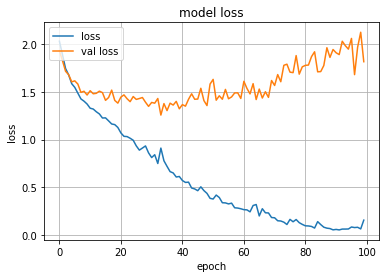

In [49]:
plt.figure()
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['loss', 'val loss'], loc='upper left')
plt.show()

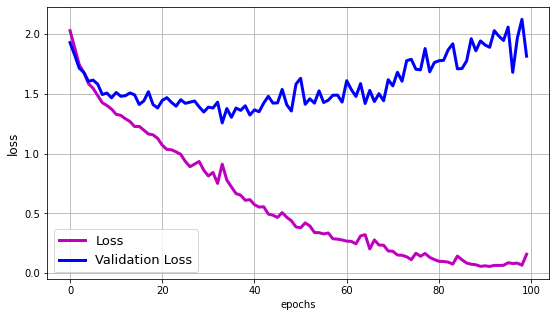

In [50]:
plt.figure(figsize=(9,5))

plt.plot(cnnhistory.history['loss'], 'm', linewidth=3)
plt.plot(cnnhistory.history['val_loss'], 'b', linewidth=3)
plt.legend(['Loss', 'Validation Loss'], fontsize=13)
plt.xlabel('epochs')
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.show()

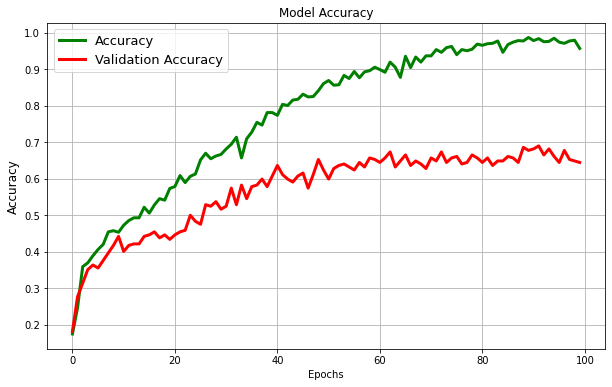

In [51]:
plt.figure(figsize=(10,6), frameon=True)

plt.plot(cnnhistory.history['accuracy'], 'g', linewidth=3)
plt.plot(cnnhistory.history['val_accuracy'], 'r', linewidth=3)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', fontsize=12)

plt.legend(['Accuracy', 'Validation Accuracy'], loc = 'upper left', fontsize=13)
plt.grid(True)
plt.show()

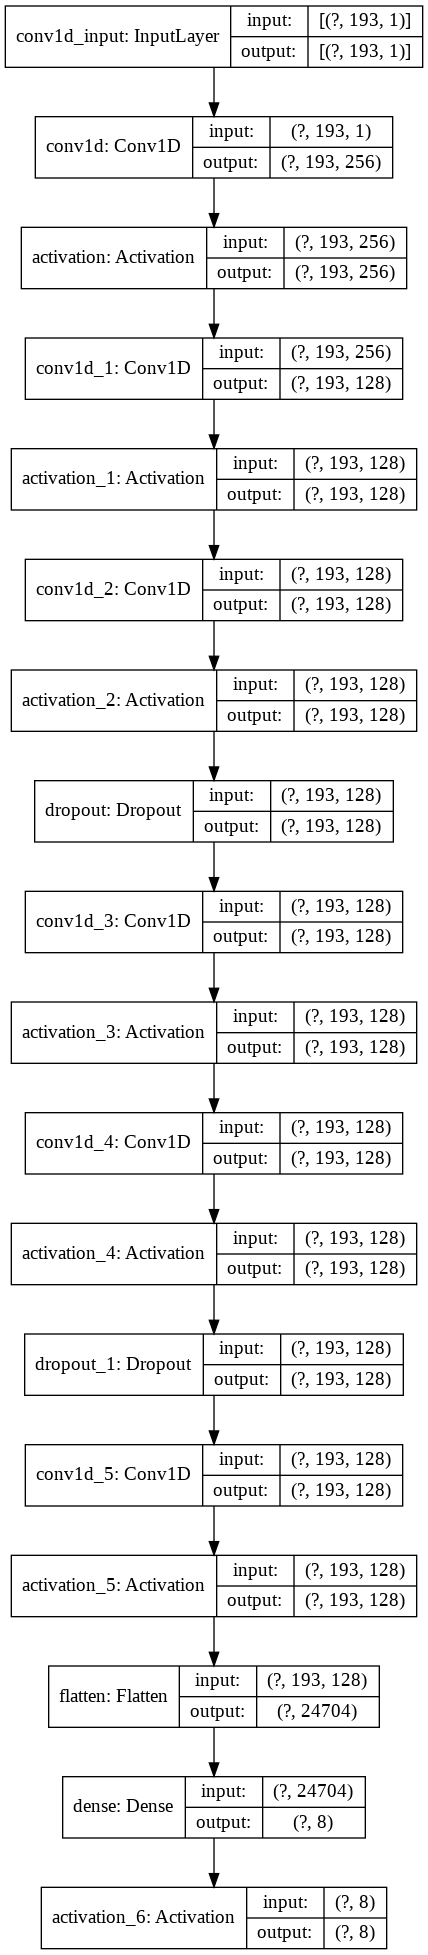

In [24]:
tf.keras.utils.plot_model(
    model,
    to_file="img_model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

dot_img_file = '/content/drive/My Drive/My_AI/img_model_MALE.png'
tf.keras.utils.plot_model(model, to_file = dot_img_file, show_shapes=True)


# **SAVING THE MODEL**

In [52]:
model_name = 'Emotion_Voice_Detection_CNN_model_10_MALE_100epochs.h5'
path = '/content/drive/My Drive/My_AI/MY MODELS/'
model_path = os.path.join(path, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/My_AI/MY MODELS/Emotion_Voice_Detection_CNN_model_10_MALE_100epochs.h5 


In [53]:
import json
model_json = model.to_json()
with open("/content/drive/My Drive/My_AI/MY MODELS/model_10_MALE_100epochs.json", "w") as json_file:
    json_file.write(model_json)

# **LOADING THE MODEL**

In [54]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('/content/drive/My Drive/My_AI/MY MODELS/model_10_MALE_100epochs.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/My_AI/MY MODELS/Emotion_Voice_Detection_CNN_model_10_MALE_100epochs.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) ###
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 64.46%


# **Predicting emotions on the test data**


In [55]:
import pandas as pd

preds = loaded_model.predict(x_testcnn, batch_size=32, verbose=1)
preds1=preds.argmax(axis=1)

abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})

actual=y_test.argmax(axis=1)

abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

actualdf = pd.DataFrame({'actualvalues': actualvalues})
finaldf = actualdf.join(preddf)

finaldf[10:70]


8/8 [==============================] - 1s 94ms/step


,actualvalues,predictedvalues
10,male_disgust,male_neutral
11,male_neutral,male_neutral
12,male_fear,male_fear
13,male_joy,male_joy
14,male_sadness,male_sadness
15,male_surprise,male_surprise
16,male_calm,male_calm
17,male_neutral,male_neutral
18,male_calm,male_calm
19,male_anger,male_joy


In [29]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_anger,29
male_calm,18
male_disgust,34
male_fear,29
male_joy,35
male_neutral,43
male_sadness,26
male_surprise,28


In [30]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_anger,31
male_calm,30
male_disgust,23
male_fear,26
male_joy,26
male_neutral,40
male_sadness,39
male_surprise,27


In [56]:
finaldf.to_csv('Predictions_10_MALE_100epochs.csv', index=False)

In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))


               precision    recall  f1-score   support

   male_anger       0.63      0.66      0.64        29
    male_calm       0.64      0.89      0.74        18
 male_disgust       0.76      0.47      0.58        34
    male_fear       0.65      0.59      0.62        29
     male_joy       0.74      0.57      0.65        35
 male_neutral       0.81      0.70      0.75        43
 male_sadness       0.47      0.81      0.59        26
male_surprise       0.55      0.61      0.58        28

     accuracy                           0.64       242
    macro avg       0.66      0.66      0.64       242
 weighted avg       0.67      0.64      0.65       242



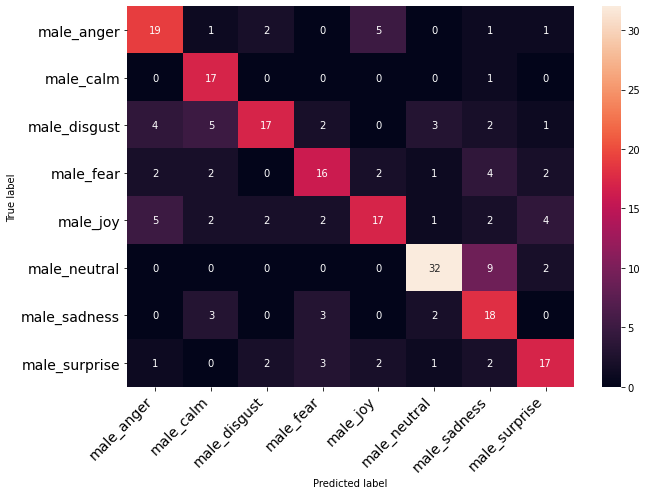

In [58]:
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'male_disgust' or 'male_fear' or 'male_joy' or 'male_sadness' or 'male_surprise' or 'male_neutral' or 'male_anger' or 'male_calm':
        return 'male'

finaldf = pd.read_csv('Predictions_10_MALE.csv')
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
#print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

# **VOICE TEST**

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


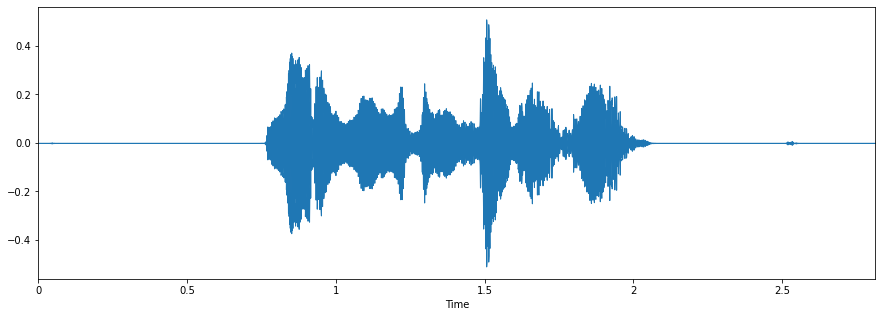

In [34]:
data, sampling_rate = librosa.load('/content/drive/My Drive/My_AI/Real Voice samples/GC-angry-H (1).wav')

% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [39]:
X, sample_rate = librosa.load('/content/drive/My Drive/My_AI/Real Voice samples/GC-angry-H (2).wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)

demo_file = os.fspath('/content/drive/My Drive/My_AI/Real Voice samples/GC-angry-H (2).wav')
features_live  = extract_feature(demo_file, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)

In [40]:
features_live = pd.DataFrame(data = features_live)
features_live = features_live.stack().to_frame().T

# **MIXING EMOTIONS**

In [37]:
import torch
features_live_2d = np.expand_dims(features_live, axis=2)
live_preds = loaded_model.predict(features_live_2d, batch_size=32, verbose = 1)
#print(live_preds)


"""
sum = 0
print('per cent:')
for i in live_preds:
  for a in i:
    sum = sum + a

for i in live_preds:
  for a in i:    
    percent = a*100/sum
    print(percent)
"""

all = np.argsort(-live_preds, axis=1)[:, :8]
for i in all:
  print((lb.inverse_transform((i))))
 
 

print()
print()
best_n = np.argsort(-live_preds)[:, :3] # best_n = [* * *]

first_second = 0
second_third = 0

for n in best_n:
  k = n
  num = 1
  for k in n:   
    #print(live_preds[0][n])
    #print(k)
    #print(n)
    if num == 1: first_second = live_preds[0][k] / live_preds[0][n][1]  
    elif num == 2: second_third = live_preds[0][k] / live_preds[0][n][2]
    num += 1


for i in best_n:
  print((lb.inverse_transform((i))))

print()
print('First/Second:')
print(first_second)
print('Second/Third:')
print(second_third)


1/1 [==============================] - 0s 1ms/step
['male_fear' 'male_joy' 'male_disgust' 'male_surprise' 'male_sadness'
 'male_anger' 'male_neutral' 'male_calm']


['male_fear' 'male_joy' 'male_disgust']

First/Second:
4.0337296
Second/Third:
7.589971


combinations-emotions.png

In [41]:
for i in best_n:
  first_emo = lb.inverse_transform((i))[0][5:]
  second_emo = lb.inverse_transform((i))[1][5:]
  third_emo = lb.inverse_transform((i))[2][5:]

emotion = ''
intensity_emo = ''
mixed_emo = ''

if first_second >= 10000:
  emotion = first_emo

elif first_second >= 200:
  #mix intensity
  if first_emo == 'disgust' and second_emo == 'anger': intensity_emo = 'distant' 
  elif first_emo == 'anger' and second_emo == 'disgust': intensity_emo = 'irritation'  
  elif first_emo == 'disgust' and second_emo == 'sadness': intensity_emo = 'guilt'
  elif first_emo == 'sadness' and second_emo == 'disgust': intensity_emo = 'miserable'
  elif first_emo == 'sadness' and second_emo == 'fear': intensity_emo = 'anxious'
  elif first_emo == 'fear' and second_emo == 'sadness': intensity_emo = 'desperate'
  elif first_emo == 'fear' and second_emo == 'joy': intensity_emo = 'astonished'
  elif first_emo == 'joy' and second_emo == 'fear': intensity_emo = 'determined'
  #elif first_emo == '' and second_emo == '': intensity_emo = ''
  #elif first_emo == '' and second_emo == '': intensity_emo = ''

#elif second_third >= 100:
  #mix intensity

if first_second < 200: # in this case the first and second emos are close to equal 
  # mix
  if first_emo == 'disgust' or second_emo == 'disgust':
    if first_emo == 'sadness' or second_emo == 'sadness': emotion = 'remorse'
    elif first_emo == 'neutral' or second_emo == 'neutral': emotion = 'neutral disgust'
    elif first_emo == 'anger' or second_emo == 'anger': emotion = 'contempt'
    elif first_emo == 'fear' or second_emo == 'fear': emotion = 'shame'
    elif first_emo == 'joy' or second_emo == 'joy': emotion = 'morbidness'
    elif first_emo == 'surprise' or second_emo == 'surprise': emotion = 'unbelief'

  elif first_emo == 'fear' or second_emo == 'fear':
    if first_emo == 'neutral' or second_emo == 'neutral': emotion = 'neutral fear'
    elif first_emo == 'joy' or second_emo == 'joy': emotion = 'guilt'         #????
    elif first_emo == 'sadness' or second_emo == 'sadness': emotion = 'despair'
    elif first_emo == 'surprise' or second_emo == 'surprise': emotion = 'awe'
  
  elif first_emo == 'anger' or second_emo == 'anger':
    if first_emo == 'neutral' or second_emo == 'neutral': emotion = 'neutral anger'
    elif first_emo == 'joy' or second_emo == 'joy': emotion = 'pride' 
    elif first_emo == 'surprise' or second_emo == 'surprise': emotion = 'outrage'   

  elif first_emo == 'joy' or second_emo == 'joy':
    if first_emo == 'neutral' or second_emo == 'neutral': emotion = 'neutral joy'  
    elif first_emo == 'surprise' or second_emo == 'surprise': emotion = 'delight' 

  elif first_emo == 'sadness' or second_emo == 'sadness':
    if first_emo == 'neutral' or second_emo == 'neutral': emotion = 'neutral sadness'  
    elif first_emo == 'surprise' or second_emo == 'surprise': emotion = 'disappointment' 
    elif first_emo == 'anger' or second_emo == 'anger': emotion = 'envy'

else: emotion = first_emo

if second_third < 200:    # in this case the second and third emos are close to equal 
 # mix
  if third_emo == 'disgust' or second_emo == 'disgust':
    if third_emo == 'sadness' or second_emo == 'sadness': mixed_emo = 'remorse'
    elif third_emo == 'neutral' or second_emo == 'neutral': mixed_emo = 'neutral disgust'
    elif third_emo == 'anger' or second_emo == 'anger': mixed_emo = 'contempt'
    elif third_emo == 'fear' or second_emo == 'fear': mixed_emo = 'shame'
    elif third_emo == 'joy' or second_emo == 'joy': mixed_emo = 'morbidness'
    elif third_emo == 'surprise' or second_emo == 'surprise': mixed_emo = 'unbelief'

  elif third_emo == 'fear' or second_emo == 'fear':
    if third_emo == 'neutral' or second_emo == 'neutral': mixed_emo = 'neutral fear'
    elif third_emo == 'joy' or second_emo == 'joy': mixed_emo = 'guilt'         #????
    elif third_emo == 'sadness' or second_emo == 'sadness': mixed_emo = 'despair'
    elif third_emo == 'surprise' or second_emo == 'surprise': mixed_emo = 'awe'
  
  elif third_emo == 'anger' or second_emo == 'anger':
    if third_emo == 'neutral' or second_emo == 'neutral': mixed_emo = 'neutral anger'
    elif third_emo == 'joy' or second_emo == 'joy': mixed_emo = 'pride' 
    elif third_emo == 'surprise' or second_emo == 'surprise': mixed_emo = 'outrage'   

  elif third_emo == 'joy' or second_emo == 'joy':
    if third_emo == 'neutral' or second_emo == 'neutral': mixed_emo = 'neutral joy'  
    elif third_emo == 'surprise' or second_emo == 'surprise': mixed_emo = 'delight' 

  elif third_emo == 'sadness' or second_emo == 'sadness':
    if third_emo == 'neutral' or second_emo == 'neutral': mixed_emo = 'neutral sadness'  
    elif third_emo == 'surprise' or second_emo == 'surprise': mixed_emo = 'disappointment' 
    elif third_emo == 'anger' or second_emo == 'anger': mixed_emo = 'envy'

  '''
  if second_emo == 'disgust':
    if third_emo == 'neutral': 
      mixed_emo = 'neutral disgust'
    elif third_emo == 'sadness': 
      mixed_emo = 'remorse'
    elif third_emo == 'anger': 
      mixed_emo = 'contempt'
    elif third_emo == 'fear': 
      mixed_emo = 'shame'
    elif third_emo == 'joy': 
      mixed_emo = 'morbidness'
    elif third_emo == 'surprise': 
      mixed_emo = 'unbelief'

  elif second_emo == 'fear':
    if third_emo == 'neutral': 
      mixed_emo = 'neutral fear'
    elif third_emo == 'joy': 
      mixed_emo = 'guilt' #????
    elif third_emo == 'sadness': 
      mixed_emo = 'despair'
    elif third_emo == 'surprise': 
      mixed_emo = 'awe'
  
  elif second_emo == 'anger':
    if third_emo == 'neutral': 
      mixed_emo = 'neutral anger'
    elif third_emo == 'joy': 
      mixed_emo = 'pride' 
    elif third_emo == 'surprise': 
      mixed_emo = 'outrage'   

  elif second_emo == 'joy':
    if third_emo == 'neutral': 
      mixed_emo = 'neutral joy'  
    elif third_emo == 'surprise': 
      mixed_emo = 'delight' 

  elif second_emo == 'sadness':
    if third_emo == 'neutral': 
      mixed_emo = 'neutral sadness'  
    elif third_emo == 'surprise': 
      mixed_emo = 'disappointment' 
    elif third_emo == 'anger': 
      mixed_emo = 'envy'
 '''

print(first_emo)
print('Main emotion:')
print(emotion)
print('Mixed emotion:')
print(mixed_emo)
print('Emotion by intensity:')
print(intensity_emo)

fear
Main emotion:
guilt
Mixed emotion:
morbidness
Emotion by intensity:



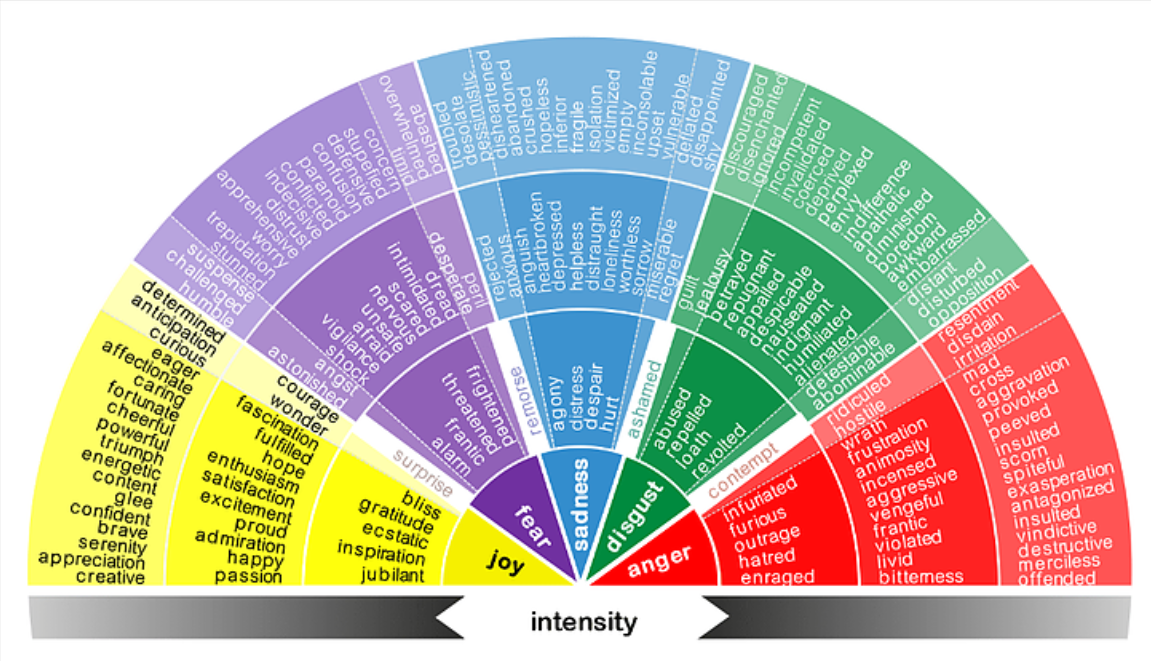

In [ ]:
model.layers[15].output

<tf.Tensor 'dense/BiasAdd_1:0' shape=(None, 8) dtype=float32>

In [ ]:

"""
print('PROBABILITY:')
layer = tf.keras.layers.Softmax()
print(layer(live_preds).numpy())



live_preds = live_preds.argmax(axis = 1)
print(live_preds)
live_preds = live_preds.astype(int).flatten()

live_preds = (lb.inverse_transform((live_preds)))
live_preds
"""


# Angry
# Calm
# Disgust
# Fearful
# Happy
# Neutral
# Sad
# Surprised



"\nprint('PROBABILITY:')\nlayer = tf.keras.layers.Softmax()\nprint(layer(live_preds).numpy())\n\n\n\nlive_preds = live_preds.argmax(axis = 1)\nprint(live_preds)\nlive_preds = live_preds.astype(int).flatten()\n\nlive_preds = (lb.inverse_transform((live_preds)))\nlive_preds\n"